### Authour
David Payne

### Description
This is a model of a directional coupler that is designed to be ultrabroadband. We are baseing the structure on this resource: https://opg.optica.org/directpdfaccess/ea886fd5-7f91-4a02-94633eb0e8020bf0_311817/oe-23-3-3795.pdf?da=1&id=311817&seq=0&mobile=no.

Because we want to use FDTD to accurately model the coupling (varFDTD and EME misestimate, see https://optics.ansys.com/hc/en-us/articles/360042304694-Evanescent-waveguide-couplers). We therefore want to use Tidy3D as we need the GPU speedup (we don't have this on Lumerical yet). We likely want particle swarm optimisation, so we are going to do it in this notebook, even though in general we are trying to avoid this. It's not an obvious candidate for inverse design because the design region is going to change in size

### Source
https://opg.optica.org/directpdfaccess/ea886fd5-7f91-4a02-94633eb0e8020bf0_311817/oe-23-3-3795.pdf?da=1&id=311817&seq=0&mobile=no


In [1]:
import gdstk
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.plugins.design as tdd
import tidy3d.web as web
from tidy3d.plugins import waveguide

In [ ]:
class broadband_coupler_simulation():
    def __init__(self):
        self.wg_width = 1.2
        self.sbend_height = 3
        self.sbend_length = 15
        self.thickness = 0.3
        self.gap =  0.3
        self.Lstraight = 10
        self.length_from_coupler = 5
        self.lda0 = 1.55  # central wavelength
        self.freq0 = td.C_0 / self.lda0  # central frequency
        self.ldas = np.linspace(1.45, 1.65, 31)  # wavelength range: broadband as we want to make it a broadband DC
        self.freqs = td.C_0 / self.ldas  # frequency range
        self.fwidth = 0.5 * (self.freqs[0] - self.freqs[-1])  # width of the source frequency range

        n_sin = 2.0  # silicon refractive index
        self.sin = td.Medium(permittivity=n_sin**2)

        n_sio2 = 1.44  # silicon oxide refractive index
        self.sio2 = td.Medium(permittivity=n_sio2**2)

        self.sim = None

    def build_top_half(self, L1, L2, Lt, delta_w):
        top_y = self.gap/2 + self.wg_width/2

        start_x = -self.sbend_length - L1 - L2/2 - Lt - self.Lstraight - 5
        end_x = self.sbend_length + L1 + L2/2 + Lt + self.Lstraight
        top_path = gdstk.RobustPath((start_x, top_y+self.sbend_height), self.wg_width, layer=1, datatype=0)

        # 1. Initial straight before S-bend
        top_path.segment((-self.sbend_length - L1 - L2/2 - Lt, top_y), self.wg_width)

        # 2. S-bend (up)
        top_path.segment((-L1 - L2/2 - Lt, top_y), self.wg_width,
            offset=lambda u: self.sbend_height * np.cos(np.pi * u) / 2 + self.sbend_height / 2)

        # 3. Straight sections through taper
        top_path.segment((-L2/2 - Lt, top_y), self.wg_width)
        top_path.segment((-L2/2, top_y + delta_w / 2), self.wg_width + delta_w)
        top_path.segment((L2/2, top_y + delta_w / 2), self.wg_width + delta_w)
        top_path.segment((L2/2 + Lt, top_y), self.wg_width)

        # 4. Straight after taper, before S-bend (down)
        top_path.segment((L1 + L2/2 + Lt, top_y), self.wg_width)

        # 5. S-bend (down)
        top_path.segment((self.sbend_length + L1 + L2/2 + Lt, top_y), self.wg_width,
            offset=lambda u: -self.sbend_height * np.cos(np.pi * u) / 2 + self.sbend_height / 2)

        # 6. Final straight after S-bend
        top_path.segment((end_x, top_y), self.wg_width)
        return top_path

    def build_bot_half(self, L1, L2, Lt, delta_w):
        bottom_y = -self.gap/2 - self.wg_width/2    
        bot_y = -self.gap/2 - self.wg_width/2
        start_x = -self.sbend_length - L1 - L2/2 - Lt - self.Lstraight - 5

        end_x = self.sbend_length + L1 + L2/2 + Lt + self.Lstraight

        bot_path = gdstk.RobustPath((start_x, bot_y-self.sbend_height), self.wg_width, layer=1, datatype=0)

        # 1. Initial straight before S-bend
        bot_path.segment((-self.sbend_length - L1 - L2/2 - Lt, bot_y), self.wg_width)

        # 2. S-bend (down)
        bot_path.segment((-L1 - L2/2 - Lt, bot_y), self.wg_width,
            offset=lambda u: -self.sbend_height * np.cos(np.pi * u) / 2 - self.sbend_height / 2)

        # 3. Taper sections
        bot_path.segment((-L2/2 - Lt, bot_y), self.wg_width)
        bot_path.segment((-L2/2, bot_y - delta_w / 2), self.wg_width - delta_w)
        bot_path.segment((L2/2, bot_y - delta_w / 2), self.wg_width - delta_w)
        bot_path.segment((L2/2 + Lt, bot_y), self.wg_width)

        # 4. Straight after taper, before S-bend (up)
        bot_path.segment((L1 + L2/2 + Lt, bot_y), self.wg_width)

        # 5. S-bend (up)
        bot_path.segment((self.sbend_length + L1 + L2/2 + Lt, bot_y), self.wg_width,
            offset=lambda u: self.sbend_height * np.cos(np.pi * u) / 2 - self.sbend_height / 2)

        # 6. Final straight after S-bend
        bot_path.segment((end_x, bot_y), self.wg_width)
        return bot_path

    def define_optimize_region(self, L1 = 5, L2 = 2, Lt = 2, delta_w = 0.2):
        cell = gdstk.Cell("broadband_dc")
        cell.add(self.build_top_half(L1, L2, Lt, delta_w))
        cell.add(self.build_bot_half(L1, L2, Lt, delta_w))
        return td.Geometry.from_gds(cell, gds_layer = 1, axis = 2, slab_bounds = (-self.thickness/2, self.thickness/2))


    def get_modes(self, delta_w):
        symmetric_coupler = waveguide.RectangularDielectric(wavelength = self.lda0, 
                                                            core_width = (self.wg_width - delta_w, self.wg_width + delta_w), 
                                                            core_thickness=self.thickness,
                                                            core_medium=self.sin, 
                                                            clad_medium=self.sio2,
                                                            gap = self.gap + delta_w,
                                                            grid_resolution=40,
                                                            mode_spec=td.ModeSpec(num_modes = 5, precision = "double"))
        # compute the effective indices for the symmetric and anti-symmetric modes
        n_p = symmetric_coupler.n_eff.values[0][0]
        n_m = symmetric_coupler.n_eff.values[0][1]
        del_n = n_p - n_m
        print(f"Effective indices: {n_p}, {n_m}")
        if delta_w != 0:
            self.pc_indices = n_p, n_m
        else:
            self.coupling_indices = n_p, n_m

        # plot the mode profiles
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

        symmetric_coupler.plot_field("Ey", mode_index=0, ax=ax1)
        symmetric_coupler.plot_field("Ey", mode_index=1, ax=ax2)
        return n_p, n_m
    
    def get_taper_theta(self, Lt, delta_w, position = "top", run = True):
        args = locals().copy()
        args.pop("self")
        sim_details = args  

        cell = gdstk.Cell("broadband_dc")
        L1, L2 = 10, 10
        if position == "top":
            cell.add(self.build_top_half(L1, L2, Lt, delta_w)) # The L1, L2 values don't matter here
            taper = td.Geometry.from_gds(cell, gds_layer = 1, axis = 2, slab_bounds = (-self.thickness/2, self.thickness/2))
            y_position = self.gap/2 + self.wg_width/2
        elif position == "bot":
            cell.add(self.build_bot_half(L1, L2, Lt, delta_w)) # The L1, L2 values don't matter here
            taper = td.Geometry.from_gds(cell, gds_layer = 1, axis = 2, slab_bounds = (-self.thickness/2, self.thickness/2))
            y_position = -self.gap/2 - self.wg_width/2
        
        taper_start_x = -Lt - L2/2

        source = td.ModeSource(name = "in1", 
                           center = (taper_start_x - 2, y_position, 0),
                           size = (0, 3*self.wg_width, 3),
                           num_freqs=5,
                           direction = "+",
                           source_time = td.GaussianPulse(freq0=self.freq0, fwidth=self.fwidth, amplitude = 1.0),
                           mode_index=0,
                           mode_spec=td.ModeSpec(num_modes=2, angle_theta=theta, angle_phi=phi)

                           )
        monitor_taper_start = td.ModeMonitor(center = (taper_start_x, y_position, 0),
                                         size = (0, 3*self.wg_width, 3),
                                         freqs = self.freqs,
                                         name = "taper_start_mon"
                                         )
        monitor_taper_end = td.ModeMonitor(center = (taper_start_x + Lt, y_position, 0),
                                           size = (0, 3*self.wg_width, 3),
                                            freqs = self.freqs,
                                            name = "taper_mon_end"
                                    )
        
        field = td.FieldMonitor(center = (0, 0, 0), size = (td.inf, td.inf, 0), name = "field_monitor", freqs = self.freqs)

        device = td.Structure(geometry=taper, medium=self.sin, background_medium=self.sio2)

                # Define simulation
        sim = td.Simulation(
                    center=(taper_start_x + Lt/2, y_position, 0),
                    size=(Lt + 10, 2*(self.wg_width + delta_w), 4),
                    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=self.lda0),
                    structures=[device],
                    sources=[source],
                    monitors=[monitor_taper_start, monitor_taper_end, field],
                    run_time=5*2*(Lt + 10)*1e-6/3e8,
                    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
                    medium=self.sio2
        )
        sim.plot_3d()

      
        name = f"broadband_dc_taper_{position}" + "_".join([f"{k}={v}" for k,v in sim_details.items()])
        if run:
            result = web.run(sim, task_name = name, path = name + ".hdf5", folder_name = "broadband_dc")
            phase_diff = np.unwrap(np.angle(result["taper_start_mon"].amps.sel(mode_index=0, direction="+")) - np.angle(result["taper_mon_end"].amps.sel(mode_index=0, direction="+")))
            transmission = np.abs(result["taper_mon_end"].amps.sel(mode_index=0, direction="+"))**2
            if "position" == "top":
                self.theta1 = phase_diff
            if "position" == "bot":
                self.theta2 = phase_diff
            return result, phase_diff, transmission
        else:
            return sim


    
    # def get_taper_theta_bot(self, Lt, delta_w):

        
    
    def build_simulation(self, L1 = 5, L2 = 2, Lt = 1, delta_w = 0.2, show_plot = True):
        args = locals().copy()
        args.pop("self")
        self.sim_details = args        
        print(self.sim_details)

        optimize_region_geo = self.define_optimize_region(L1, L2, Lt, delta_w)
        # Define input port center and direction vector
        print(self.sbend_length, L1, L2/2, Lt, self.Lstraight)
        start_x = -self.sbend_length - L1 - L2/2 - Lt - self.Lstraight - 5
        top_y = self.wg_width/2 + self.gap/2
        bot_y = -self.wg_width/2 - self.gap/2
        length_from_coupler = self.length_from_coupler
        # Example: 20 degrees below horizontal, angled in x-y plane
        xsource = -L2/2 - Lt - L1 - length_from_coupler
        angle_source = 0.5*np.atan(-self.sbend_height*np.pi/self.sbend_length*np.sin(np.pi*(self.sbend_length - length_from_coupler)/self.sbend_length))

        xmon = L2/2 + Lt + L1 + length_from_coupler

        ysbend = self.sbend_height/2*(1 - np.cos(length_from_coupler*np.pi/self.sbend_length))
        source = td.ModeSource(name = "in1", 
                           center = (xsource, self.gap/2 + self.wg_width/2 + ysbend, 0),
                           size = (0, 2*(self.gap + self.wg_width/2 + ysbend), 3),
                           num_freqs=5,
                           direction = "+",
                           source_time = td.GaussianPulse(freq0=self.freq0, fwidth=self.fwidth, amplitude = 1.0),
                           mode_index=0,
                           mode_spec=td.ModeSpec(num_modes = 5, angle_theta=angle_source)
                           )
        
        monitor_through = td.ModeMonitor(center = (xmon, self.gap/2 + self.wg_width/2 + ysbend, 0),
                                         size = (0,  2*(self.gap + self.wg_width/2 + ysbend), 3),
                                         freqs = self.freqs,
                                         name = "mode_monitor_through",
                                        mode_spec=td.ModeSpec(num_modes = 5, angle_theta=-angle_source),
                                        store_fields_direction = "+")
        monitor_cross = td.ModeMonitor(center = (xmon, -self.gap/2 - self.wg_width/2 - ysbend, 0),
                                         size = (0,  2*(self.gap + self.wg_width/2 + ysbend), 3),
                                         freqs = self.freqs,
                                         name = "mode_monitor_cross",
                                        mode_spec=td.ModeSpec(num_modes = 5, angle_theta=angle_source),
                                        store_fields_direction = "+")

        field = td.FieldMonitor(center = (0, 0, 0), size = (td.inf, td.inf, 0), name = "field_monitor", freqs = self.freqs)

        device = td.Structure(geometry=optimize_region_geo, medium=self.sin, background_medium=self.sio2)

                # Define simulation
        sim = td.Simulation(
                center=(0, 0, 0),
                size=(xmon - xsource + 4, 2*(ysbend+self.wg_width+self.gap) + 7, 5),
                grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=self.lda0),
                structures=[device],
                sources=[source],
                monitors=[monitor_through, monitor_cross, field],
                run_time=5*2*(2*self.sbend_length + 2*L1 + L2 + 2*Lt+8)*1e-6/3e8,
                boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
                medium=self.sio2
        )
        # sim.plot(z = 0)
        if show_plot:
            sim.plot_3d()
        self.sim = sim
        return sim

    def run_sim(self):
        if self.sim is None:
            self.build_simulation()
        print("broadband_dc_" + "_".join([f"{k}={v}" for k,v in self.sim_details.items()]))
        self.sim_results = web.run(self.sim, task_name="broadband_dc_" + "_".join([f"{k}={v}" for k,v in self.sim_details.items()]), path='broadband_dc.hdf5', folder_name = "broadband_dc")
        return self.sim_results

    def fn_pre(self, **params : dict) -> td.Simulation:
        """Take parameters suggested by PSO and output a dict of sims"""
        length_parameters = np.array(list(params.values()))
        sim = self.build_simulation(*length_parameters)
        return sim
    
    def fn_post(self):
        Pthrough = np.abs(self.sim_results.monitor_data["mode_monitor_through"].amps[0, :, 0])**2
        Pcross = np.abs(self.sim_results.monitor_data["mode_monitor_through"].amps[0, :, 0])**2
        P_through_at_1550nm = Pthrough[np.argmin(np.abs(self.ldas - self.lda0))]
        P_cross_at_1550nm = Pcross[np.argmin(np.abs(self.ldas - self.lda0))]
        return np.mean(2*np.min([Pthrough, Pcross], axis = 0)) ## Designed to try to get them both to be equal, and as high transmission as possible


    def start_PSO(self, particles = 10):
        self.nparticles = particles
        init_pos = np.array([5, 5, 7.5, 0.2])
        bounds = ((0, 25), (0, 25), (0, 20), (0.05, self.wg_width - 0.4)) 
        init_pos = np.column_stack([np.random.uniform(low, high, self.nparticles) for (low, high) in bounds])        
        particle_swarm = tdd.MethodParticleSwarm(name = "bb_dc_PSO",    
                                                 seed = 1, 
                                                 n_particles=self.nparticles,
                                                 n_iter=10, 
                                                 cognitive_coeff=1, 
                                                 social_coeff=1, 
                                                 ftol = 0.001, 
                                                 ftol_iter = 10,
                                                 init_pos = init_pos
        )
        parameters = [tdd.ParameterFloat(name = param_name, span = param_bounds) for param_name, param_bounds in zip(["L1", "L2", "Lt", "delta_w"], list(bounds))]
        design_space = tdd.DesignSpace(method = particle_swarm, parameters = parameters)

        return design_space.run(self.fn_pre, self.fn_post, verbose = True)

    

def plot_parameter_space(self, 
                            theta_t1 : float, 
                            theta_t2 : float, 
                            coupling_indices : tuple[float, float],
                            pc_indices : tuple[float, float]):
        # input field vector
    E_in = np.array([[0], [1]])

    N_L1 = 100  # number of L_1 points
    N_L2 = 50  # number of L_2 points
    L_1_array = np.linspace(4, 20, N_L1)
    L_2_array = np.linspace(1, 6, N_L2)

    eta_cross_1550 = np.zeros((N_L1, N_L2))
    coupling_indices = coupling_indices 
    pc_indices = pc_indices 
    theta_t1 = theta_t1
    theta_t2 = theta_t2 

    # compute the taper matrix
    P_t = np.array([[np.exp(-1j * theta_t1[50]), 0], [0, np.exp(-1j * theta_t2[50])]]) * np.exp(-0.5)

    for i, L_1 in enumerate(L_1_array):
        for j, L_2 in enumerate(L_2_array):
            # compute the transmission coefficient
            t = np.cos(np.pi * abs(coupling_indices[1] - coupling_indices[0]) * L_1 / self.lda0)
            # compute the coupling coefficient
            k = np.sin(np.pi * abs(coupling_indices[1] - coupling_indices[0]) * L_1 / self.lda0)
            # compute the symmetric coupler matrix
            C = np.exp(-1j * np.pi * (coupling_indices[0] + coupling_indices[0]) * L_1 / self.lda0) * np.array([[t, -1j * k], [-1j * k, t]])
            # compute the phase control section matrix
            P = np.array(
                [
                    [np.exp(-1j * 2 * np.pi * pc_indices[0] * L_2 / self.lda0), 0],
                    [0, np.exp(-1j * 2 * np.pi * pc_indices[1] * L_2 / self.lda0)],
                ]
            )
            # compute the output field vector by tmm
            E_out = np.dot(C, np.dot(P_t, np.dot(P, np.dot(P_t, np.dot(C, E_in)))))

            # total transmission
            T = np.abs(E_out[0, 0]) ** 2 + np.abs(E_out[1, 0]) ** 2
            # power transmitted to the cross port
            eta_cross_1550[i, j] = np.abs(E_out[0, 0]) ** 2 / T
    




In [ ]:
simulation = broadband_coupler_simulation()
simulation.length_from_coupler = 4
simulation.build_simulation(10, 5, 5, 0.2)
simulation.sim.plot(z=0)
PSO_output = simulation.start_PSO()

{'L1': 10, 'L2': 5, 'Lt': 5, 'delta_w': 0.2}
15 10 2.5 5 10


[GDSTK] No intersection found in RobustPath right side construction around (2.5, 0.15) and (7.5, 0.15).
[GDSTK] No intersection found in RobustPath right side construction around (-7.5, -1.35) and (-2.5, -1.35).


2025-08-08 16:50:01,411 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.0, 'c2': 1.0, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10

{'L1': np.float64(23.621936105941543), 'L2': np.float64(13.790247181844064), 'Lt': np.float64(13.584363480139192), 'delta_w': np.float64(0.2537131568680909)}
15 23.621936105941543 6.895123590922032 13.584363480139192 10


{'L1': np.float64(13.760429027824378), 'L2': np.float64(23.62517982900867), 'Lt': np.float64(11.129024477473838), 'delta_w': np.float64(0.37917621984120803)}
15 13.760429027824378 11.812589914504334 11.129024477473838 10


[GDSTK] No intersection found in RobustPath right side construction around (11.8126, 0.15) and (22.9416, 0.15).


{'L1': np.float64(21.914489102605106), 'L2': np.float64(10.169538650784396), 'Lt': np.float64(0.7294329648071085), 'delta_w': np.float64(0.4399759275970522)}
15 21.914489102605106 5.084769325392198 0.7294329648071085 10


[GDSTK] No intersection found in RobustPath right side construction around (5.08477, 0.15) and (5.8142, 0.15).
[GDSTK] No intersection found in RobustPath right side construction around (-5.8142, -1.35) and (-5.08477, -1.35).


{'L1': np.float64(0.35384059988610717), 'L2': np.float64(1.787366301418933), 'Lt': np.float64(12.677965936557316), 'delta_w': np.float64(0.6253863374376468)}
15 0.35384059988610717 0.8936831507094665 12.677965936557316 10


[GDSTK] No intersection found in RobustPath right side construction around (0.893683, 0.15) and (13.5716, 0.15).


{'L1': np.float64(8.771594375124758), 'L2': np.float64(15.647735790099784), 'Lt': np.float64(14.725520429872198), 'delta_w': np.float64(0.20878934989829928)}
15 8.771594375124758 7.823867895049892 14.725520429872198 10


{'L1': np.float64(12.522949571071054), 'L2': np.float64(24.064972946392736), 'Lt': np.float64(4.8564123934446535), 'delta_w': np.float64(0.330673035796876)}
15 12.522949571071054 12.032486473196368 4.8564123934446535 10


[GDSTK] No intersection found in RobustPath right side construction around (12.0325, 0.15) and (16.8889, 0.15).
[GDSTK] No intersection found in RobustPath right side construction around (-16.8889, -1.35) and (-12.0325, -1.35).


[GDSTK] No intersection found in RobustPath right side construction around (2.59996, 0.15) and (5.60752, 0.15).
[GDSTK] No intersection found in RobustPath right side construction around (-5.60752, -1.35) and (-2.59996, -1.35).


{'L1': np.float64(16.384890287795038), 'L2': np.float64(5.199928602424447), 'Lt': np.float64(3.0075518713109495), 'delta_w': np.float64(0.5805809721228403)}
15 16.384890287795038 2.5999643012122235 3.0075518713109495 10


{'L1': np.float64(19.306870973626427), 'L2': np.float64(7.667428654098968), 'Lt': np.float64(14.585761400378782), 'delta_w': np.float64(0.1193534874596405)}
15 19.306870973626427 3.833714327049484 14.585761400378782 10


{'L1': np.float64(14.79934036081313), 'L2': np.float64(21.83573662237579), 'Lt': np.float64(8.364993647301862), 'delta_w': np.float64(0.06431125114465454)}
15 14.79934036081313 10.917868311187895 8.364993647301862 10


{'L1': np.float64(5.047301786023239), 'L2': np.float64(11.988537225166631), 'Lt': np.float64(15.816228960973755), 'delta_w': np.float64(0.6100877783086502)}
15 5.047301786023239 5.994268612583316 15.816228960973755 10


[GDSTK] No intersection found in RobustPath right side construction around (5.99427, 0.15) and (21.8105, 0.15).


16:50:01 BST Running 10 Simulations

{'L1': 10, 'L2': 5, 'Lt': 5, 'delta_w': 0.2}


[GDSTK] No intersection found in RobustPath right side construction around (2.5, 0.15) and (7.5, 0.15).
[GDSTK] No intersection found in RobustPath right side construction around (-7.5, -1.35) and (-2.5, -1.35).


broadband_dc_L1=10_L2=5_Lt=5_delta_w=0.2


15:32:44 BST Created task 'broadband_dc_L1=10_L2=5_Lt=5_delta_w=0.2' with       
             task_id 'fdve-b34c983a-aafd-4dc6-8417-c9581e9b829d' and task_type  
             'FDTD'.

             View task using web UI at                                          
             ]8;id=405591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b34c983a-aafd-4dc6-8417-c9581e9b829d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=334011;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b34c983a-aafd-4dc6-8417-c9581e9b829d\taskId]8;;\]8;id=405591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b34c983a-aafd-4dc6-8417-c9581e9b829d\=]8;;\]8;id=9034;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b34c983a-aafd-4dc6-8417-c9581e9b829d\fdve]8;;\]8;id=405591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b34c983a-aafd-4dc6-8417-c9581e9b829d\-b34c983a-aaf]8;;\
             ]8;id=405591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b34c983a-aafd-4dc6-8417-c9581e9b829d\d-4dc6-8417-c9581e9b829d']8;;\.

15:32:45 BST Task folder: ]8;id=384248;https://tidy3d.simulation.cloud/folders/folder-5c474501-7fae-4d15-9d3b-8d2b72a77405\'broadband_dc']8;;\.

Output()

15:32:47 BST Maximum FlexCredit cost: 0.921. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

15:32:48 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

15:33:00 BST status = preprocess

15:33:07 BST starting up solver

             running solver

Output()

15:33:38 BST early shutoff detected at 28%, exiting.

             status = postprocess

Output()

15:35:36 BST status = success

15:35:38 BST View simulation result at                                          
             ]8;id=822426;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b34c983a-aafd-4dc6-8417-c9581e9b829d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=747793;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b34c983a-aafd-4dc6-8417-c9581e9b829d\taskId]8;;\]8;id=822426;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b34c983a-aafd-4dc6-8417-c9581e9b829d\=]8;;\]8;id=408117;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b34c983a-aafd-4dc6-8417-c9581e9b829d\fdve]8;;\]8;id=822426;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b34c983a-aafd-4dc6-8417-c9581e9b829d\-b34c983a-aaf]8;;\
             ]8;id=822426;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b34c983a-aafd-4dc6-8417-c9581e9b829d\d-4dc6-8417-c9581e9b829d']8;;\.

Output()

15:36:33 BST loading simulation from broadband_dc.hdf5

SimulationData(attrs={}, simulation=Simulation(attrs={}, type='Simulation', center=(0.0, 0.0, 0.0), size=(50.0, 14.5, 5.0), medium=Medium(attrs={}, name=None, frequency_range=None, allow_gain=False, nonlinear_spec=None, modulation_spec=None, viz_spec=None, heat_spec=None, type='Medium', permittivity=2.0736, conductivity=0.0), structures=(Structure(attrs={}, geometry=GeometryGroup(attrs={}, type='GeometryGroup', geometries=(PolySlab(attrs={}, type='PolySlab', axis=2, sidewall_angle=0.0, reference_plane='middle', slab_bounds=(-0.15, 0.15), dilation=0.0, vertices=array([[-4.76176697e+01,  3.16165159e+00],
       [-4.73823303e+01,  4.33834841e+00],
       [-4.36905877e+01,  4.35000000e+00],
       [-3.99405877e+01,  4.35000000e+00],
       [-3.61905877e+01,  4.35000000e+00],
       [-3.24382423e+01,  4.34987929e+00],
       [-3.14640991e+01,  4.31615468e+00],
       [-3.04918554e+01,  4.22402183e+00],
       [-2.95230697e+01,  4.07747632e+00],
       [-2.85589411e+01,  3.88275981e+00],
   

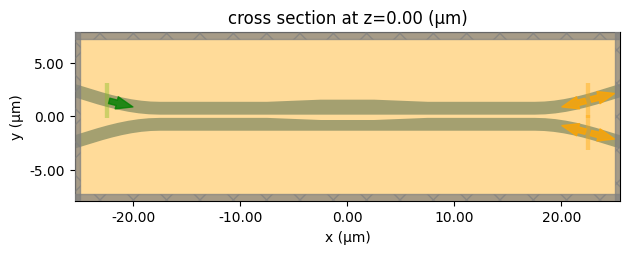

In [461]:
simulation = broadband_coupler_simulation()
simulation.build_simulation(10, 5, 5, 0.2)
simulation.sim.plot(z=0)
simulation.run_sim()

### Particle swarm optimisation
We've spent some time getting a rough idea of where might be good initial parameters. Let's now just run the particle swarm and see what happens

{'L1': 30, 'L2': 10, 'Lt': 10, 'delta_w': 0.2}


<Axes: title={'center': 'cross section at z=0.00 (μm)'}, xlabel='x (μm)', ylabel='y (μm)'>

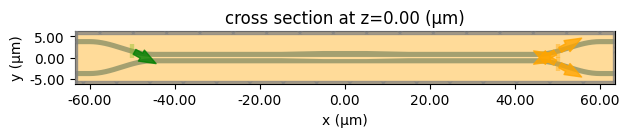

In [ ]:
simulation = broadband_coupler_simulation()
simulation.build_simulation(30, 10, 10, 0.2)


In [ ]:
simulation = broadband_coupler_simulation()
simulation.build_simulation(30, 10, 10, 0.2)
simulation.gap = 0.3
simul



{'L1': 30, 'L2': 10, 'Lt': 10, 'delta_w': 0.2}


In [ ]:
simulation = broadband_coupler_simulation()
simulation.gap = 0.3
nc1, nc2 = simulation.get_modes(0)

Effective indices: 1.609604785099473, 1.5887641581434189
Effective indices: 1.609824394154372, 1.5855587963703663
Effective indices: 1.6151978170379877, 1.574783200022557
Effective indices: 1.620787856041927, 1.560789030029261
Effective indices: 1.6262152000203967, 1.5434844970943848
Effective indices: 1.6308078417387724, 1.5321265205524601
Effective indices: 1.6349416116063402, 1.5346895805586003
Effective indices: 1.63831421257295, 1.53666385898943
Effective indices: 1.6414839653150626, 1.5442193756743157
Effective indices: 1.6440901200387996, 1.5537879497038252


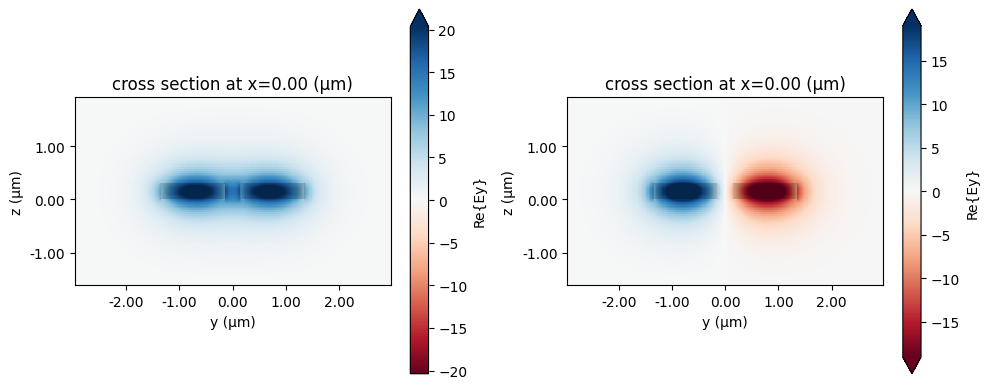

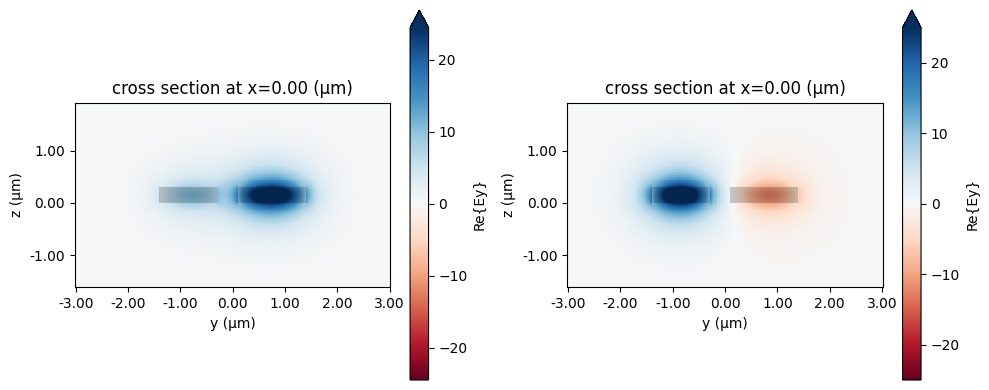

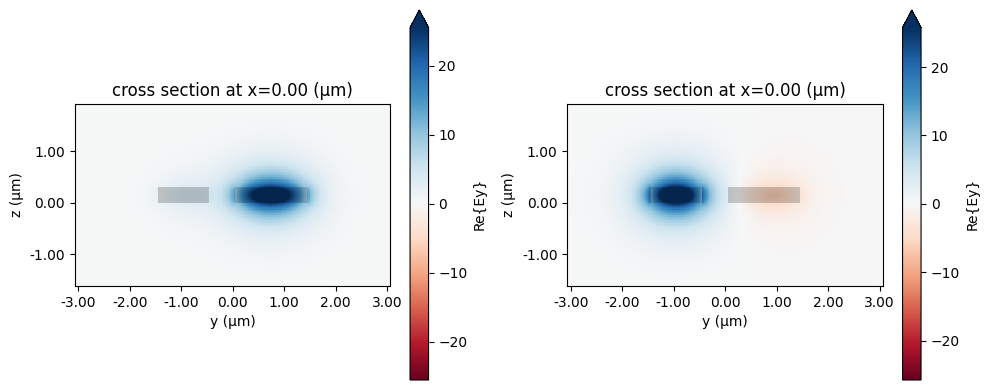

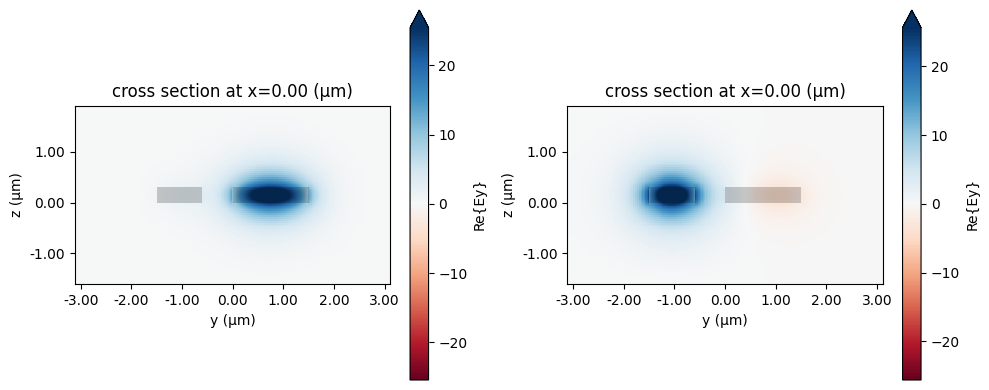

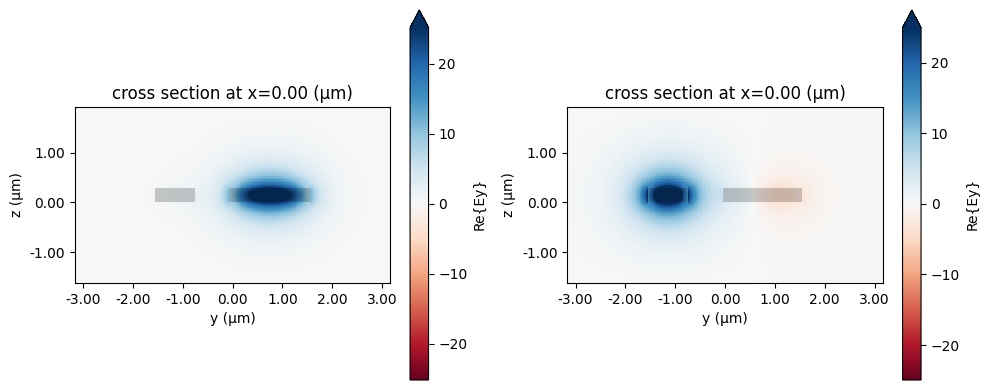

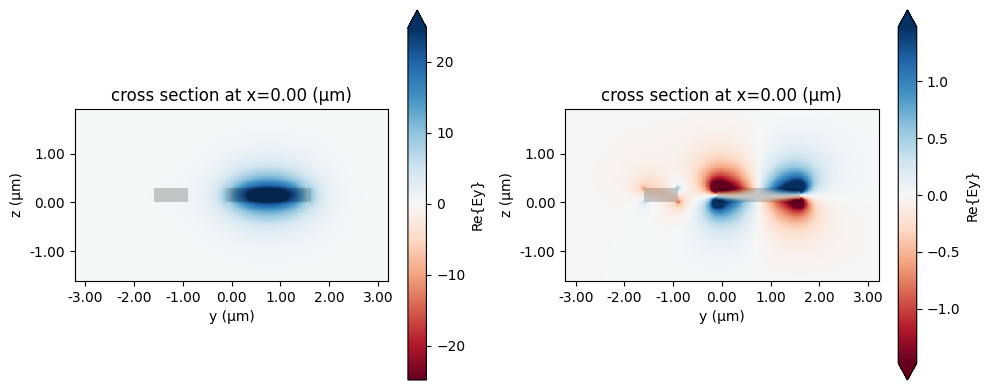

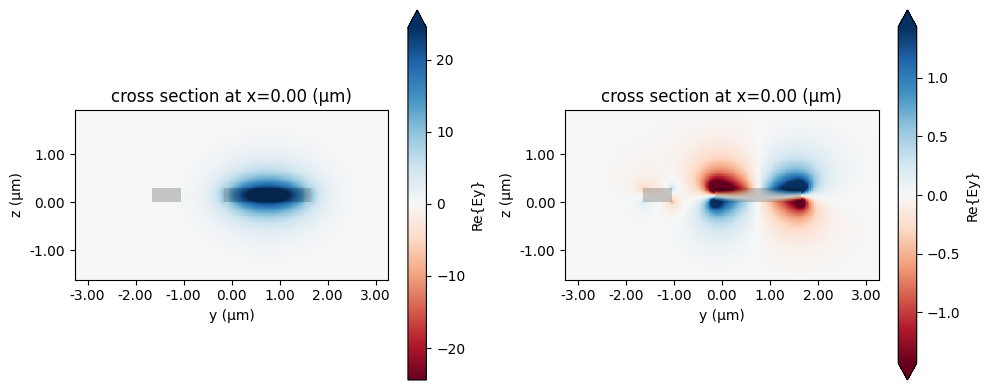

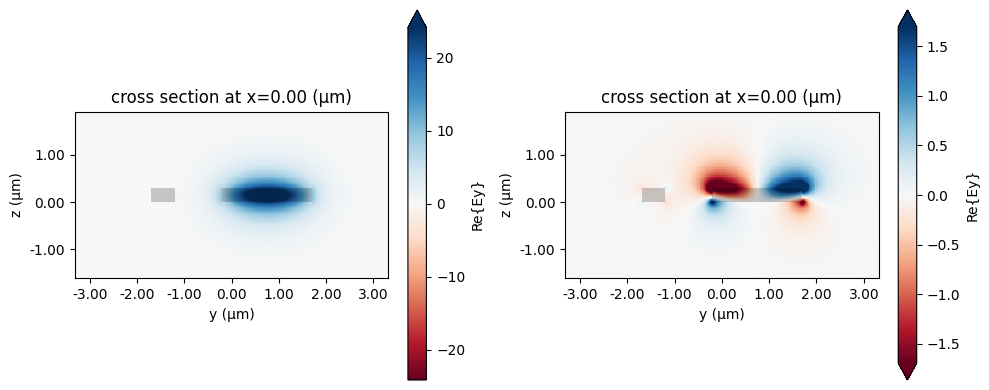

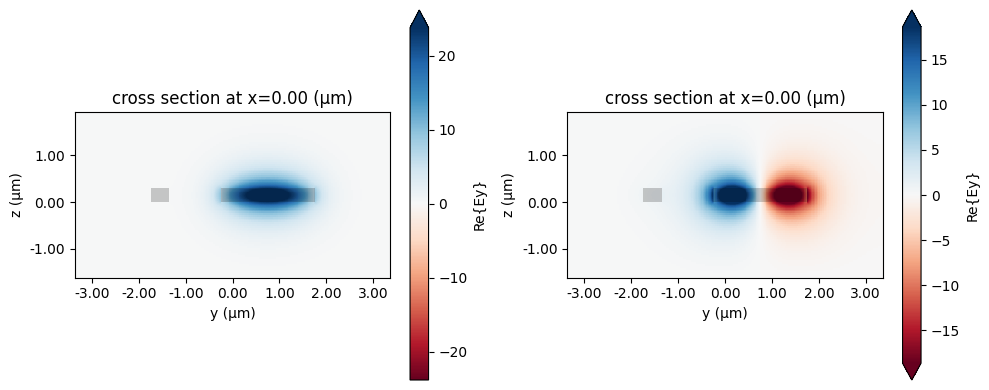

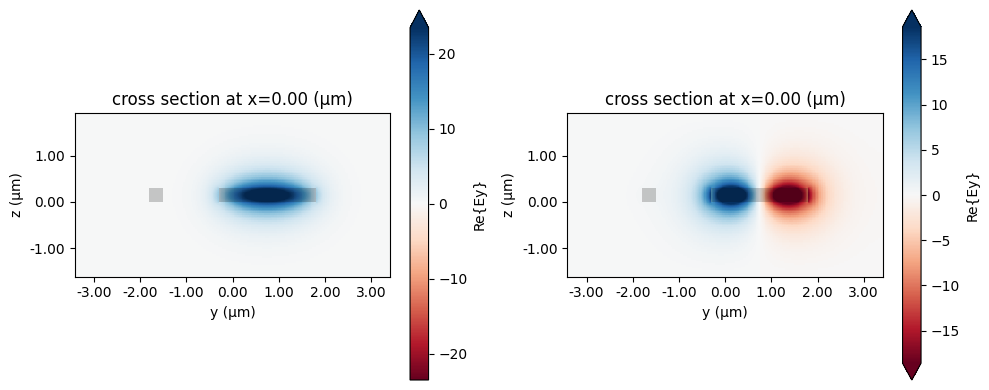

In [384]:
results = []
simulation = broadband_coupler_simulation()
simulation.gap = 0.3
dns = []
dws = np.arange(0, 1, 0.1)
for dw in dws:
    n1, n2 = simulation.get_modes(dw)
    dns.append(abs(n1-n2))


In [402]:
simulation = broadband_coupler_simulation()
phase_values = []
T_values = []
fig1 = plt.figure()
fig2 = plt.figure()
for taper_length in [5, 7.5, 10]:
    # taper_sim, phase, T = simulation.get_taper_theta(Lt = taper_length, delta_w = 0.4, run = False)
    _ = simulation.get_taper_theta(Lt = taper_length, delta_w = 0.4, run = False)

    # phase_values.append(phase)
    # T_values.append(T)
    # plt.figure(fig1)
    # plt.plot(simulation.ldas, phase, label = taper_length)
    # plt.figure(fig2)
    # plt.plot(simulation.ldas, T, label = taper_length)

[GDSTK] No intersection found in RobustPath right side construction around (5, 0.15) and (10, 0.15).


[GDSTK] No intersection found in RobustPath right side construction around (5, 0.15) and (12.5, 0.15).


[GDSTK] No intersection found in RobustPath right side construction around (5, 0.15) and (15, 0.15).


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
results = []
simulation = broadband_coupler_simulation()
simulation.gap = 0.4
for L1 in [0, 5, 10, 15]:
    simulation.build_simulation(L1 = L1, L2 = 0, Lt = 0, delta_w = 0)
    result = simulation.run_sim()
    results.append(result)


{'L1': 0, 'L2': 0, 'Lt': 0, 'delta_w': 0}


[GDSTK] No intersection found in RobustPath left side construction around (2.96088e-05, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (2.96088e-05, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (2.96088e-05, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (2.96088e-05, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (2.96088e-05, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (-2.96088e-05, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (-2.96088e-05, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (-2.96088e-05, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (-2.96088e-05, 0.15) an

broadband_dc_L1=0_L2=0_Lt=0_delta_w=0


10:36:40 BST Created task 'broadband_dc' with task_id                           
             'fdve-aa1e296a-604c-40c5-b023-ef5aae831189' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=535045;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa1e296a-604c-40c5-b023-ef5aae831189\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=219801;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa1e296a-604c-40c5-b023-ef5aae831189\taskId]8;;\]8;id=535045;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa1e296a-604c-40c5-b023-ef5aae831189\=]8;;\]8;id=216264;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa1e296a-604c-40c5-b023-ef5aae831189\fdve]8;;\]8;id=535045;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa1e296a-604c-40c5-b023-ef5aae831189\-aa1e296a-604]8;;\
             ]8;id=535045;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa1e296a-604c-40c5-b023-ef5aae831189\c-40c5-b023-ef5aae831189']8;;\.

             Task folder: ]8;id=547185;https://tidy3d.simulation.cloud/folders/folder-5c474501-7fae-4d15-9d3b-8d2b72a77405\'broadband_dc']8;;\.

Output()

10:36:43 BST Maximum FlexCredit cost: 0.405. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

10:36:44 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

10:36:51 BST status = preprocess

10:36:58 BST starting up solver

             running solver

Output()

10:37:42 BST early shutoff detected at 16%, exiting.

10:37:43 BST status = postprocess

Output()

10:37:45 BST status = success

10:37:47 BST View simulation result at                                          
             ]8;id=473710;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa1e296a-604c-40c5-b023-ef5aae831189\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=546610;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa1e296a-604c-40c5-b023-ef5aae831189\taskId]8;;\]8;id=473710;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa1e296a-604c-40c5-b023-ef5aae831189\=]8;;\]8;id=87266;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa1e296a-604c-40c5-b023-ef5aae831189\fdve]8;;\]8;id=473710;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa1e296a-604c-40c5-b023-ef5aae831189\-aa1e296a-604]8;;\
             ]8;id=473710;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa1e296a-604c-40c5-b023-ef5aae831189\c-40c5-b023-ef5aae831189']8;;\.

Output()

10:37:49 BST loading simulation from broadband_dc.hdf5

{'L1': 5, 'L2': 0, 'Lt': 0, 'delta_w': 0}


[GDSTK] No intersection found in RobustPath left side construction around (0, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (0, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (0, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (0, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, -0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, -0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, -0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (

broadband_dc_L1=5_L2=0_Lt=0_delta_w=0


             Created task 'broadband_dc' with task_id                           
             'fdve-59080451-c344-486b-a33e-f1ae984ed987' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=735112;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59080451-c344-486b-a33e-f1ae984ed987\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=370409;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59080451-c344-486b-a33e-f1ae984ed987\taskId]8;;\]8;id=735112;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59080451-c344-486b-a33e-f1ae984ed987\=]8;;\]8;id=464819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59080451-c344-486b-a33e-f1ae984ed987\fdve]8;;\]8;id=735112;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59080451-c344-486b-a33e-f1ae984ed987\-59080451-c34]8;;\
             ]8;id=735112;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59080451-c344-486b-a33e-f1ae984ed987\4-486b-a33e-f1ae984ed987']8;;\.

             Task folder: ]8;id=132825;https://tidy3d.simulation.cloud/folders/folder-5c474501-7fae-4d15-9d3b-8d2b72a77405\'broadband_dc']8;;\.

Output()

10:37:52 BST Maximum FlexCredit cost: 0.625. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

10:37:53 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

10:37:58 BST status = preprocess

10:38:07 BST starting up solver

10:38:08 BST running solver

Output()

10:38:49 BST early shutoff detected at 16%, exiting.

             status = postprocess

Output()

10:38:51 BST status = success

10:38:53 BST View simulation result at                                          
             ]8;id=616145;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59080451-c344-486b-a33e-f1ae984ed987\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=601731;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59080451-c344-486b-a33e-f1ae984ed987\taskId]8;;\]8;id=616145;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59080451-c344-486b-a33e-f1ae984ed987\=]8;;\]8;id=800092;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59080451-c344-486b-a33e-f1ae984ed987\fdve]8;;\]8;id=616145;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59080451-c344-486b-a33e-f1ae984ed987\-59080451-c34]8;;\
             ]8;id=616145;https://tidy3d.simulation.cloud/workbench?taskId=fdve-59080451-c344-486b-a33e-f1ae984ed987\4-486b-a33e-f1ae984ed987']8;;\.

Output()

10:38:55 BST loading simulation from broadband_dc.hdf5

{'L1': 10, 'L2': 0, 'Lt': 0, 'delta_w': 0}


[GDSTK] No intersection found in RobustPath left side construction around (0, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (0, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (0, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (0, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, -0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, -0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, -0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (

broadband_dc_L1=10_L2=0_Lt=0_delta_w=0


10:38:56 BST Created task 'broadband_dc' with task_id                           
             'fdve-e0804f10-9e3a-4dd0-a64f-b7b7b1d2340e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=802332;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0804f10-9e3a-4dd0-a64f-b7b7b1d2340e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=918069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0804f10-9e3a-4dd0-a64f-b7b7b1d2340e\taskId]8;;\]8;id=802332;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0804f10-9e3a-4dd0-a64f-b7b7b1d2340e\=]8;;\]8;id=885539;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0804f10-9e3a-4dd0-a64f-b7b7b1d2340e\fdve]8;;\]8;id=802332;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0804f10-9e3a-4dd0-a64f-b7b7b1d2340e\-e0804f10-9e3]8;;\
             ]8;id=802332;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0804f10-9e3a-4dd0-a64f-b7b7b1d2340e\a-4dd0-a64f-b7b7b1d2340e']8;;\.

             Task folder: ]8;id=460876;https://tidy3d.simulation.cloud/folders/folder-5c474501-7fae-4d15-9d3b-8d2b72a77405\'broadband_dc']8;;\.

Output()

10:38:58 BST Maximum FlexCredit cost: 0.894. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

10:38:59 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

10:39:04 BST status = preprocess

10:39:13 BST starting up solver

             running solver

Output()

10:39:53 BST early shutoff detected at 16%, exiting.

             status = success

             View simulation result at                                          
             ]8;id=463932;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0804f10-9e3a-4dd0-a64f-b7b7b1d2340e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=112406;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0804f10-9e3a-4dd0-a64f-b7b7b1d2340e\taskId]8;;\]8;id=463932;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0804f10-9e3a-4dd0-a64f-b7b7b1d2340e\=]8;;\]8;id=557498;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0804f10-9e3a-4dd0-a64f-b7b7b1d2340e\fdve]8;;\]8;id=463932;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0804f10-9e3a-4dd0-a64f-b7b7b1d2340e\-e0804f10-9e3]8;;\
             ]8;id=463932;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0804f10-9e3a-4dd0-a64f-b7b7b1d2340e\a-4dd0-a64f-b7b7b1d2340e']8;;\.

Output()

10:39:55 BST loading simulation from broadband_dc.hdf5

{'L1': 15, 'L2': 0, 'Lt': 0, 'delta_w': 0}


[GDSTK] No intersection found in RobustPath left side construction around (0, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (0, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (0, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (0, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, -0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, -0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, -0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (

broadband_dc_L1=15_L2=0_Lt=0_delta_w=0


             Created task 'broadband_dc' with task_id                           
             'fdve-60c234e4-e73e-4c49-bf4a-b1b91c07b813' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=692063;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c234e4-e73e-4c49-bf4a-b1b91c07b813\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=989019;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c234e4-e73e-4c49-bf4a-b1b91c07b813\taskId]8;;\]8;id=692063;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c234e4-e73e-4c49-bf4a-b1b91c07b813\=]8;;\]8;id=463691;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c234e4-e73e-4c49-bf4a-b1b91c07b813\fdve]8;;\]8;id=692063;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c234e4-e73e-4c49-bf4a-b1b91c07b813\-60c234e4-e73]8;;\
             ]8;id=692063;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c234e4-e73e-4c49-bf4a-b1b91c07b813\e-4c49-bf4a-b1b91c07b813']8;;\.

             Task folder: ]8;id=611326;https://tidy3d.simulation.cloud/folders/folder-5c474501-7fae-4d15-9d3b-8d2b72a77405\'broadband_dc']8;;\.

Output()

10:39:57 BST Maximum FlexCredit cost: 1.211. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

10:39:59 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

10:40:04 BST status = preprocess

10:40:15 BST starting up solver

10:40:16 BST running solver

Output()

10:41:01 BST early shutoff detected at 16%, exiting.

             status = success

             View simulation result at                                          
             ]8;id=727659;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c234e4-e73e-4c49-bf4a-b1b91c07b813\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=440021;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c234e4-e73e-4c49-bf4a-b1b91c07b813\taskId]8;;\]8;id=727659;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c234e4-e73e-4c49-bf4a-b1b91c07b813\=]8;;\]8;id=231922;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c234e4-e73e-4c49-bf4a-b1b91c07b813\fdve]8;;\]8;id=727659;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c234e4-e73e-4c49-bf4a-b1b91c07b813\-60c234e4-e73]8;;\
             ]8;id=727659;https://tidy3d.simulation.cloud/workbench?taskId=fdve-60c234e4-e73e-4c49-bf4a-b1b91c07b813\e-4c49-bf4a-b1b91c07b813']8;;\.

Output()

10:41:03 BST loading simulation from broadband_dc.hdf5

attrs={} simulation=Simulation(attrs={}, type='Simulation', center=(0.0, 0.0, 0.0), size=(38.0, 11.0, 5.0), medium=Medium(attrs={}, name=None, frequency_range=None, allow_gain=False, nonlinear_spec=None, modulation_spec=None, viz_spec=None, heat_spec=None, type='Medium', permittivity=2.0736, conductivity=0.0), structures=(Structure(attrs={}, geometry=GeometryGroup(attrs={}, type='GeometryGroup', geometries=(PolySlab(attrs={}, type='PolySlab', axis=2, sidewall_angle=0.0, reference_plane='middle', slab_bounds=(-0.15, 0.15), dilation=0.0, vertices=array([[-3.01176697e+01,  3.16165159e+00],
       [-2.98823303e+01,  4.33834841e+00],
       [-2.61905877e+01,  4.35000000e+00],
       [-2.24405877e+01,  4.35000000e+00],
       [-1.86905877e+01,  4.35000000e+00],
       [-1.49382423e+01,  4.34987929e+00],
       [-1.39640991e+01,  4.31615468e+00],
       [-1.29918554e+01,  4.22402183e+00],
       [-1.20230697e+01,  4.07747632e+00],
       [-1.10589411e+01,  3.88275981e+00],
       [-1.01002791

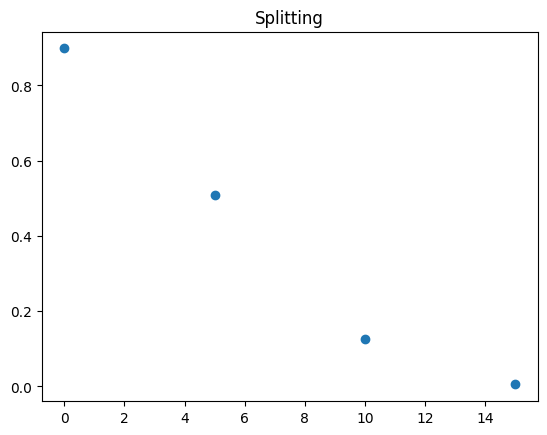

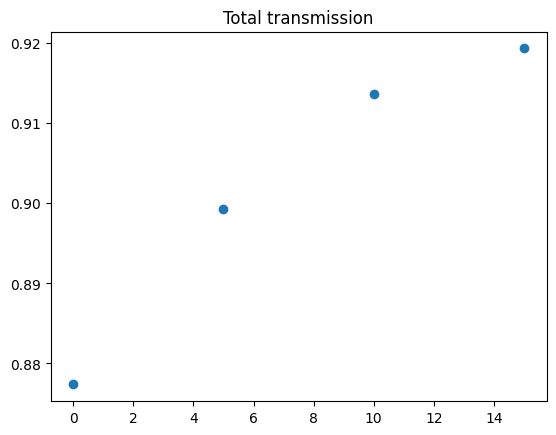

In [303]:
fig1 = plt.figure()
fig2 = plt.figure()

wl = 1.55
c0 = 2.99792458e8  # speed of light in vacuum in um/s
T_through_near_1550 = []
T_cross_near_1550 = []
coupling_lengths_used = [0, 5, 10, 15]

for result, length in zip(results, coupling_lengths_used):
    print(result)
    through = result.monitor_data["mode_monitor_through"]
    cross = result.monitor_data["mode_monitor_cross"]
    # print(through.freqs)
    # plt.plot(through.amps[1, :, 0])
    print(np.abs(through.amps[0, np.argmin(np.abs(wl - simulation.ldas)), 0])**2)
    T_through_near_1550.append(np.abs(through.amps[0, np.argmin(np.abs(wl - simulation.ldas)), 0])**2)
    T_cross_near_1550.append(np.abs(cross.amps[0, np.argmin(np.abs(wl - simulation.ldas)), 0])**2)

T_through_near_1550  = np.array(T_through_near_1550)
T_cross_near_1550  = np.array(T_cross_near_1550)

plt.figure(fig1)
plt.title("Splitting")
plt.plot(coupling_lengths_used, T_through_near_1550/(T_through_near_1550 +T_cross_near_1550), "o", label=f"L1={length}um")
plt.figure(fig2)
plt.title("Total transmission")
plt.plot(coupling_lengths_used, T_through_near_1550 +T_cross_near_1550, "o", label=f"L1={length}um")


In [307]:
simulation.sbend_length = 25
simulation.sbend_height = 5
print(simulation.sbend_height)
simulation.build_simulation(L1 = 5, L2 = 0, Lt = 0, delta_w = 0)


3
{'L1': 5, 'L2': 0, 'Lt': 0, 'delta_w': 0}


[GDSTK] No intersection found in RobustPath left side construction around (0, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, 1.35) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (0, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (0, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (0, 0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, -0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, -0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath left side construction around (0, -0.15) and (-nan, -nan).
[GDSTK] No intersection found in RobustPath right side construction around (

broadband_dc_L1=5_L2=0_Lt=0_delta_w=0


11:21:17 BST Created task 'broadband_dc' with task_id                           
             'fdve-82d7d7dd-720f-42e0-ad2e-d55794840e0f' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=498827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d7d7dd-720f-42e0-ad2e-d55794840e0f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=76511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d7d7dd-720f-42e0-ad2e-d55794840e0f\taskId]8;;\]8;id=498827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d7d7dd-720f-42e0-ad2e-d55794840e0f\=]8;;\]8;id=308721;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d7d7dd-720f-42e0-ad2e-d55794840e0f\fdve]8;;\]8;id=498827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d7d7dd-720f-42e0-ad2e-d55794840e0f\-82d7d7dd-720]8;;\
             ]8;id=498827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d7d7dd-720f-42e0-ad2e-d55794840e0f\f-42e0-ad2e-d55794840e0f']8;;\.

             Task folder: ]8;id=192449;https://tidy3d.simulation.cloud/folders/folder-5c474501-7fae-4d15-9d3b-8d2b72a77405\'broadband_dc']8;;\.

Output()

11:21:20 BST Maximum FlexCredit cost: 1.211. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

11:21:22 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:21:29 BST status = preprocess

11:21:36 BST starting up solver

             running solver

Output()

11:22:21 BST early shutoff detected at 16%, exiting.

             status = postprocess

Output()

11:22:23 BST status = success

11:22:25 BST View simulation result at                                          
             ]8;id=440941;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d7d7dd-720f-42e0-ad2e-d55794840e0f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=654491;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d7d7dd-720f-42e0-ad2e-d55794840e0f\taskId]8;;\]8;id=440941;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d7d7dd-720f-42e0-ad2e-d55794840e0f\=]8;;\]8;id=491565;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d7d7dd-720f-42e0-ad2e-d55794840e0f\fdve]8;;\]8;id=440941;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d7d7dd-720f-42e0-ad2e-d55794840e0f\-82d7d7dd-720]8;;\
             ]8;id=440941;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82d7d7dd-720f-42e0-ad2e-d55794840e0f\f-42e0-ad2e-d55794840e0f']8;;\.

Output()

11:22:27 BST loading simulation from broadband_dc.hdf5

In [ ]:
result2 = td.web.load()